In [1]:
# Import dependencies
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
# Read csv file
data = pd.read_csv('./Resources/Sales_Area_Data/Sales/final_sales_data.csv')

# Keep only rows from 2019 for training; drop 2020 and 2021 data
index_names = data[data['year'] != 2019].index
data.drop(index_names, inplace = True)

data = data.sort_values(by=['zipcode', 'month'], axis=0)
  
data.head()

,Unnamed: 0,zipcode,year,month,total_sales,avg_sale_price,med_sale_price,mortgage_rate
5589,5589,32003,2019,1,32,289290.0,244950.0,4.4640
5700,5700,32003,2019,2,41,286173.0,270000.0,4.3700
5804,5804,32003,2019,3,21,301620.0,275000.0,4.2650
5908,5908,32003,2019,4,42,263475.0,264500.0,4.1425
6022,6022,32003,2019,5,66,293816.0,281000.0,4.0720


In [3]:
data = data.groupby(['zipcode','month'])['med_sale_price'].agg(['sum']).reset_index()
data = data.pivot_table(values='sum', columns='month', index='zipcode')
data.columns.name = None
data = data.reset_index()

data.head()

,zipcode,1,2,3,4,5,6,7,8,9,10,11,12
0,32003,244950.0,270000.0,275000.0,264500.0,281000.0,275000.0,282500.0,269577.0,286000.0,258000.0,283000.0,286500.0
1,32008,86000.0,106250.0,NaN,121500.0,74150.0,138750.0,92500.0,150000.0,100500.0,132000.0,126000.0,194250.0
2,32009,275000.0,95000.0,115000.0,NaN,74868.0,185000.0,240000.0,NaN,47100.0,242000.0,180000.0,352500.0
3,32011,270000.0,150000.0,134000.0,180000.0,232500.0,88400.0,220000.0,145500.0,172500.0,160000.0,134000.0,142000.0
4,32024,162500.0,90000.0,81950.0,156450.0,165850.0,139300.0,145000.0,90000.0,104000.0,160500.0,185000.0,139000.0


In [4]:
data.dtypes

zipcode      int64
1          float64
2          float64
3          float64
4          float64
5          float64
6          float64
7          float64
8          float64
9          float64
10         float64
11         float64
12         float64
dtype: object

In [5]:
melt = data.melt(id_vars='zipcode', var_name='month', value_name='med_sale_price')

melt['zipcode'] = melt['zipcode']
melt['month'] = melt['month']

melt = melt.sort_values(['month', 'zipcode'])
melt.head(3000)

,zipcode,month,med_sale_price
0,32003,1,244950.0
1,32008,1,86000.0
2,32009,1,275000.0
3,32011,1,270000.0
4,32024,1,162500.0
...,...,...,...
2995,32343,4,136365.0
2996,32344,4,153750.0
2997,32346,4,217450.0
2998,32347,4,82600.0


In [6]:
melt.dtypes

zipcode             int64
month              object
med_sale_price    float64
dtype: object

In [7]:
melt.astype({'month': 'float64'}).dtypes


zipcode             int64
month             float64
med_sale_price    float64
dtype: object

In [8]:
index = melt.index
number_of_rows = len(index)
 
print(number_of_rows)

11412


In [9]:
melt2 = melt.copy()
melt2['last_month_sales'] = melt2.groupby(['zipcode'])['med_sale_price'].shift()
melt2['last_month_diff'] = melt2.groupby(['zipcode'])['last_month_sales'].diff()
melt2 = melt2.dropna()
melt2.head()

,zipcode,month,med_sale_price,last_month_sales,last_month_diff
1902,32003,3,275000.0,270000.0,25050.0
1904,32009,3,115000.0,95000.0,-180000.0
1905,32011,3,134000.0,150000.0,-120000.0
1906,32024,3,81950.0,90000.0,-72500.0
1907,32025,3,87000.0,95500.0,-12750.0


In [10]:
index = melt2.index
number_of_rows = len(index)
 
print(number_of_rows)

8762


In [11]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

### Establishing Baseline

In [12]:
mean_error = []
for month in range(11,13):
    train = melt2[melt2['month'] < month]
    val = melt2[melt2['month'] == month]

    p = val['last_month_sales'].values

    error = rmsle(val['med_sale_price'].values, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)

print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.29350
Month 12 - Error 0.29439
Mean Error = 0.29394


In [13]:
melt2.dtypes

zipcode               int64
month                object
med_sale_price      float64
last_month_sales    float64
last_month_diff     float64
dtype: object

### Training

In [14]:
mean_error = []
for month in range(11,13):
    train = melt2[melt2['month'] < month]
    val = melt2[melt2['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(xtr, ytr)

    p = model.predict(xts)

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.28124
Month 12 - Error 0.23199
Mean Error = 0.25662


In [15]:
melt3 = melt.copy()
melt3['Last_Month_Sales'] = melt3.groupby(['zipcode'])['med_sale_price'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['zipcode'])['Last_Month_Sales'].diff()
melt3['Last-1_Month_Sales'] = melt3.groupby(['zipcode'])['med_sale_price'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['zipcode'])['Last-1_Month_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,zipcode,month,med_sale_price,Last_Month_Sales,Last_Month_Diff,Last-1_Month_Sales,Last-1_Month_Diff
2853,32003,4,264500.0,275000.0,5000.0,270000.0,25050.0
2856,32011,4,180000.0,134000.0,-16000.0,150000.0,-120000.0
2857,32024,4,156450.0,81950.0,-8050.0,90000.0,-72500.0
2858,32025,4,105500.0,87000.0,-8500.0,95500.0,-12750.0
2859,32033,4,121500.0,255000.0,29000.0,226000.0,36000.0


In [16]:
mean_error = []
for month in range(11,13):
    train = melt3[melt3['month'] < month]
    val = melt3[melt3['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(xtr, ytr)

    p = model.predict(xts)

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.26808
Month 12 - Error 0.21092
Mean Error = 0.23950


In [17]:
melt4 = melt.copy()
melt4['Last_Month_Sales'] = melt4.groupby(['zipcode'])['med_sale_price'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['zipcode'])['Last_Month_Sales'].diff()
melt4['Last-1_Month_Sales'] = melt4.groupby(['zipcode'])['med_sale_price'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['zipcode'])['Last-1_Month_Sales'].diff()
melt4['Last-2_Month_Sales'] = melt4.groupby(['zipcode'])['med_sale_price'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['zipcode'])['Last-2_Month_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,zipcode,month,med_sale_price,Last_Month_Sales,Last_Month_Diff,Last-1_Month_Sales,Last-1_Month_Diff,Last-2_Month_Sales,Last-2_Month_Diff
3804,32003,5,281000.0,264500.0,-10500.0,275000.0,5000.0,270000.0,25050.0
3807,32011,5,232500.0,180000.0,46000.0,134000.0,-16000.0,150000.0,-120000.0
3808,32024,5,165850.0,156450.0,74500.0,81950.0,-8050.0,90000.0,-72500.0
3809,32025,5,125000.0,105500.0,18500.0,87000.0,-8500.0,95500.0,-12750.0
3810,32033,5,155250.0,121500.0,-133500.0,255000.0,29000.0,226000.0,36000.0


In [18]:
mean_error = []
for month in range(11,13):
    train = melt4[melt4['month'] < month]
    val = melt4[melt4['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(xtr, ytr)

    p = model.predict(xts)

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.24936
Month 12 - Error 0.20827
Mean Error = 0.22882


In [19]:
melt5 = melt.copy()
melt5['Last_Month_Sales'] = melt5.groupby(['zipcode'])['med_sale_price'].shift()
melt5['Last_Month_Diff'] = melt5.groupby(['zipcode'])['Last_Month_Sales'].diff()
melt5['Last-1_Month_Sales'] = melt5.groupby(['zipcode'])['med_sale_price'].shift(2)
melt5['Last-1_Month_Diff'] = melt5.groupby(['zipcode'])['Last-1_Month_Sales'].diff()
melt5['Last-2_Month_Sales'] = melt5.groupby(['zipcode'])['med_sale_price'].shift(3)
melt5['Last-2_Month_Diff'] = melt5.groupby(['zipcode'])['Last-2_Month_Sales'].diff()
melt5['Last-3_Month_Sales'] = melt5.groupby(['zipcode'])['med_sale_price'].shift(4)
melt5['Last-3_Month_Diff'] = melt5.groupby(['zipcode'])['Last-3_Month_Sales'].diff()
melt5 = melt5.dropna()
melt5.head()

,zipcode,month,med_sale_price,Last_Month_Sales,Last_Month_Diff,Last-1_Month_Sales,Last-1_Month_Diff,Last-2_Month_Sales,Last-2_Month_Diff,Last-3_Month_Sales,Last-3_Month_Diff
4755,32003,6,275000.0,281000.0,16500.0,264500.0,-10500.0,275000.0,5000.0,270000.0,25050.0
4758,32011,6,88400.0,232500.0,52500.0,180000.0,46000.0,134000.0,-16000.0,150000.0,-120000.0
4759,32024,6,139300.0,165850.0,9400.0,156450.0,74500.0,81950.0,-8050.0,90000.0,-72500.0
4760,32025,6,129000.0,125000.0,19500.0,105500.0,18500.0,87000.0,-8500.0,95500.0,-12750.0
4761,32033,6,177000.0,155250.0,33750.0,121500.0,-133500.0,255000.0,29000.0,226000.0,36000.0


In [20]:
mean_error = []
for month in range(11,13):
    train = melt5[melt5['month'] < month]
    val = melt5[melt5['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(xtr, ytr)

    p = model.predict(xts)

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.25247
Month 12 - Error 0.19325
Mean Error = 0.22286


In [21]:
melt6 = melt.copy()
melt6['Last_Month_Sales'] = melt6.groupby(['zipcode'])['med_sale_price'].shift()
melt6['Last_Month_Diff'] = melt6.groupby(['zipcode'])['Last_Month_Sales'].diff()
melt6['Last-1_Month_Sales'] = melt6.groupby(['zipcode'])['med_sale_price'].shift(2)
melt6['Last-1_Month_Diff'] = melt6.groupby(['zipcode'])['Last-1_Month_Sales'].diff()
melt6['Last-2_Month_Sales'] = melt6.groupby(['zipcode'])['med_sale_price'].shift(3)
melt6['Last-2_Month_Diff'] = melt6.groupby(['zipcode'])['Last-2_Month_Sales'].diff()
melt6['Last-3_Month_Sales'] = melt6.groupby(['zipcode'])['med_sale_price'].shift(4)
melt6['Last-3_Month_Diff'] = melt6.groupby(['zipcode'])['Last-3_Month_Sales'].diff()
melt6['Last-4_Month_Sales'] = melt6.groupby(['zipcode'])['med_sale_price'].shift(5)
melt6['Last-4_Month_Diff'] = melt6.groupby(['zipcode'])['Last-4_Month_Sales'].diff()

melt6 = melt6.dropna()
melt6.head()

,zipcode,month,med_sale_price,Last_Month_Sales,Last_Month_Diff,Last-1_Month_Sales,Last-1_Month_Diff,Last-2_Month_Sales,Last-2_Month_Diff,Last-3_Month_Sales,Last-3_Month_Diff,Last-4_Month_Sales,Last-4_Month_Diff
5706,32003,7,282500.0,275000.0,-6000.0,281000.0,16500.0,264500.0,-10500.0,275000.0,5000.0,270000.0,25050.0
5709,32011,7,220000.0,88400.0,-144100.0,232500.0,52500.0,180000.0,46000.0,134000.0,-16000.0,150000.0,-120000.0
5710,32024,7,145000.0,139300.0,-26550.0,165850.0,9400.0,156450.0,74500.0,81950.0,-8050.0,90000.0,-72500.0
5711,32025,7,120000.0,129000.0,4000.0,125000.0,19500.0,105500.0,18500.0,87000.0,-8500.0,95500.0,-12750.0
5712,32033,7,242000.0,177000.0,21750.0,155250.0,33750.0,121500.0,-133500.0,255000.0,29000.0,226000.0,36000.0


In [22]:
mean_error = []
for month in range(11,13):
    train = melt6[melt6['month'] < month]
    val = melt6[melt6['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(xtr, ytr)

    p = model.predict(xts)

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.25081
Month 12 - Error 0.18958
Mean Error = 0.22020


### Changing the fit

In [23]:
mean_error = []
for month in range(11,13):
    train = melt6[melt6['month'] < month]
    val = melt6[melt6['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(xtr, np.log1p(ytr))

    p = np.expm1(model.predict(xts))

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 11 - Error 0.23739
Month 12 - Error 0.19444
Mean Error = 0.21591


C:\Users\kimso\.conda\envs\PythonData\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kimso\.conda\envs\PythonData\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


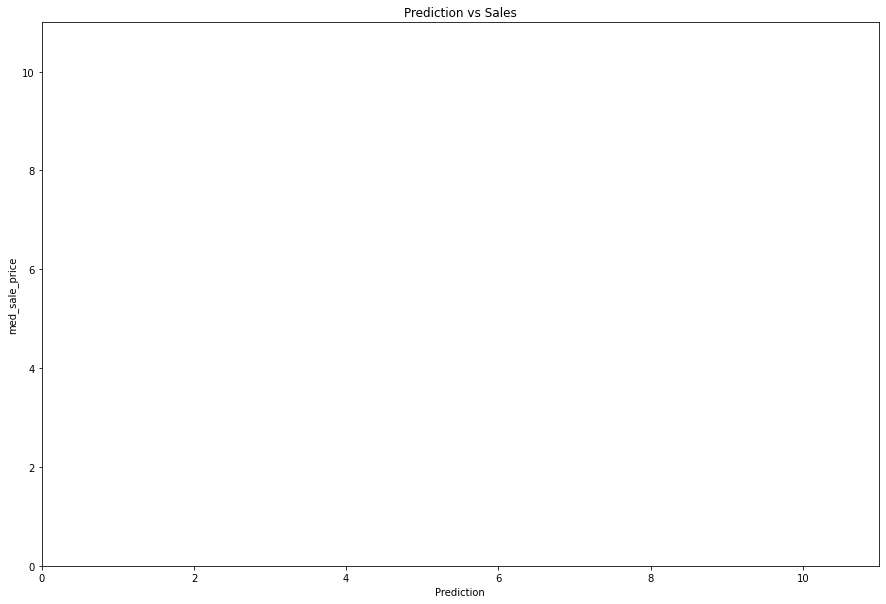

In [24]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='med_sale_price', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,11), xlim=(0,11))

### Try again later...

In [25]:
melt6.astype({'month': 'float'}).dtypes

zipcode                 int64
month                 float64
med_sale_price        float64
Last_Month_Sales      float64
Last_Month_Diff       float64
Last-1_Month_Sales    float64
Last-1_Month_Diff     float64
Last-2_Month_Sales    float64
Last-2_Month_Diff     float64
Last-3_Month_Sales    float64
Last-3_Month_Diff     float64
Last-4_Month_Sales    float64
Last-4_Month_Diff     float64
dtype: object

### Gradient Boosted Trees

In [26]:
mean_error = []
for month in range(11,13):
    train = melt6[melt6['month'] < month]
    val = melt6[melt6['month'] == month]

    xtr, xts = train.drop(['med_sale_price'], axis=1), val.drop(['med_sale_price'], axis=1)
    ytr, yts = train['med_sale_price'].values, val['med_sale_price'].values

    model = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    model.fit(xtr, np.log1p(ytr))

    p = np.expm1(model.predict(xts))

    error = rmsle(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: month